## Dataset

In [1]:
import os
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import librosa
import librosa.display
import warnings

warnings.simplefilter(action='ignore', category=Warning)

model_path = 'FullSpectrogram_model'
model_name = 'model_decay'
musdb_train_path = 'data/musdb18/preprocessed/raw/train/'
musdb_valid_path = 'data/musdb18/preprocessed/raw/valid/'
musdb_test_path = 'data/musdb18/preprocessed/raw/test/'

dim_f = 2**10
dim_t = 2**8
n_fft=2*(dim_f-1)
hop_factor = 6
hop_length=n_fft//hop_factor
sampling_rate = 44100
sampling_size = hop_length * (dim_t+hop_factor-1)
trim = 1000  # trim each generated sub-signal (noise due to conv zero-padding)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_track_dict(path, i):
    return {t: np.load(os.path.join(path, t, str(i)+'.npy')) for t in os.listdir(path)}

def to_specs(signal):
    spectrogram = librosa.stft(signal, n_fft=n_fft, center=False, hop_length=hop_length)
    r = spectrogram.real
    i = spectrogram.imag
    return r, i

def restore(ri):
    r, i = ri[0], ri[1]
    ft = r + 1.j*i
    return librosa.istft(ft, center=False, hop_length=hop_length)

class MusdbDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
    
    def __len__(self):
        return len([name for name in os.listdir(self.file_path + 'vocals')])
    
    def __getitem__(self, index):
        track = load_track_dict(self.file_path, index)
        length = track['vocals'].shape[0]
        start_index = random.randint(0, length - sampling_size)
        mix = to_specs(track['linear_mixture'][start_index:start_index+sampling_size])
        voc = to_specs(track['vocals'][start_index:start_index+sampling_size])
        return torch.tensor(mix), torch.tensor(voc) 

sampling_size

89001

## Modeling

In [2]:
class WaveUNet(nn.Module):
    def __init__(self, num_filters, fx_d, fy_d, fx_u, fy_u, num_layers):
        super(WaveUNet, self).__init__()
        
        self.ds_layers = nn.ModuleList()
        c = 2
        for i in range(num_layers):
            self.ds_layers.append(nn.Conv2d(in_channels=c, out_channels=num_filters*(i+1), 
                                            kernel_size=(fx_d, fy_d), stride=1, padding=(fx_d//2, fy_d//2)))
            self.ds_layers.append(nn.LeakyReLU())
            self.ds_layers.append(nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)))
            c = num_filters*(i+1)
            
        self.mid_conv = nn.Conv2d(in_channels=num_filters*num_layers, out_channels=num_filters*(num_layers+1), 
                                  kernel_size=(fx_d, fy_d), stride=1, padding=(fx_d//2, fy_d//2))
        
        self.us_layers = nn.ModuleList()
        for i in range(num_layers, 0, -1):
            self.us_layers.append(nn.Upsample(scale_factor=(2,2), mode='bilinear'))
            self.us_layers.append(nn.Conv2d(in_channels=num_filters*(2*i+1), out_channels=num_filters*i,
                                            kernel_size=(fx_u, fy_u), stride=1, padding=(fx_u//2, fy_u//2)))
            self.us_layers.append(nn.LeakyReLU())
        
        self.final_conv = nn.Conv2d(in_channels=num_filters+2, out_channels=2, kernel_size=1, stride=1)
         
        self.decay = 0
        self.decay_rate = 0.99995
        
    def forward(self, x):
        mixture = x
        ds_conv_outputs = []
        
        decay = self.decay_rate ** self.decay
        print('decay: ', decay)
        self.decay += 1
        
        for i in range(len(self.ds_layers)):
            x = self.ds_layers[i](x)
            if i%3==0:
                ds_conv_outputs.append(x * decay)
             
        x = self.mid_conv(x)
        
        for i in range(len(self.us_layers)):
            x = self.us_layers[i](x)
            if i%3 == 0:
                x = torch.cat((x, ds_conv_outputs[-(i//3 + 1)]), 1)
        
        x = torch.cat((x, decay * mixture), 1)
        return self.final_conv(x)

## Training 

In [3]:
import IPython.display as ipd 
import torch.optim as optim
from tqdm import tqdm_notebook


class hp:
    num_filters = 6
    num_layers = 8
    filter_size_x_d = 3
    filter_size_y_d = 3
    filter_size_x_u = 3
    filter_size_y_u = 3

train_set = MusdbDataset(file_path=musdb_train_path)
train_iter = DataLoader(train_set, batch_size=16, shuffle=True)
valid_set = MusdbDataset(file_path=musdb_valid_path)
valid_iter = DataLoader(valid_set, batch_size=len(valid_set), shuffle=True)


def init_weights(model, init_from_ckpt=False):
    if init_from_ckpt:
        model.load_state_dict(torch.load('{0}/{1}.pt'.format(model_path, model_name)))
    else:
        for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)
                
model = WaveUNet(hp.num_filters, hp.filter_size_x_d, hp.filter_size_y_d, hp.filter_size_x_u, hp.filter_size_y_u, hp.num_layers).to(device)
criterion = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr=1e-4)
init_weights(model, init_from_ckpt=False)

num_epochs = 10000
loss_trace = []
valid_loss_trace = []
smooth_loss=0
print_step=1
best_epoch=0

init_weights(model, init_from_ckpt=False)

epoch 3344
0.5123452731343203


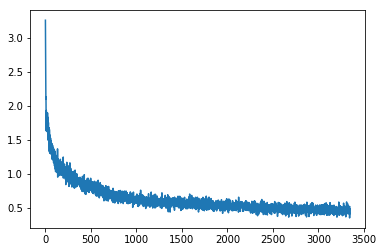

decay:  0.3665849166414193
decay:  0.3665665873955872
decay:  0.3665482590662174
decay:  0.3665299316532641


KeyboardInterrupt: 

In [4]:
for e in range(num_epochs):
    model.train()
    loss_sum = 0
    for mix, voc in tqdm_notebook(train_iter):
        mix = mix.to(device)
        voc = voc.to(device)  
        
        y_hat = model(mix)
        loss = criterion(y_hat, voc)
        loss.backward()
        optim.step()
        optim.zero_grad()
        loss_sum += loss.item() * mix.shape[0]
       
    if((e+1) % print_step == 0):
        ipd.clear_output(wait=True)
        print('epoch' , e)
        
        epoch_avg_loss = loss_sum / len(train_set)
        loss_trace.append(epoch_avg_loss)
        print(epoch_avg_loss)
        plt.plot(loss_trace)
        plt.show()
        
        torch.save(model.state_dict(), '{0}/{1}.pt'.format(model_path, model_name))


### Separation example on sub-track

In [5]:
import librosa
import IPython.display as ipd

index = 3
track = load_track_dict(musdb_valid_path, index)
s = 80
start_index = s * sampling_rate
mix = track['linear_mixture'][start_index:start_index+sampling_size]
voc = track['vocals'][start_index:start_index+sampling_size]
acc = mix-voc

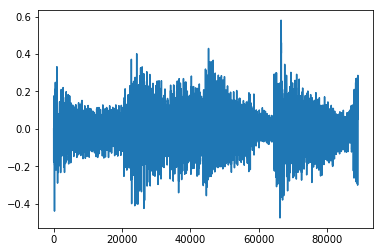

In [6]:
mix_ = restore(to_specs(mix))
plt.plot(mix_)
plt.show()
librosa.output.write_wav('{0}/temp.wav'.format(model_path), mix, 44100)
ipd.Audio('{0}/temp.wav'.format(model_path))

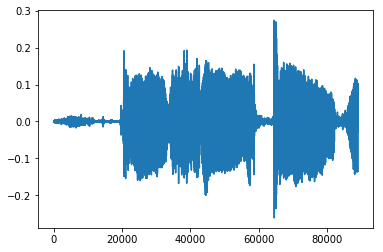

In [7]:
plt.plot(voc)
plt.show()
voc_path = '{0}/temp.wav'.format(model_path)
librosa.output.write_wav('{0}/temp.wav'.format(model_path), voc, 44100)
ipd.Audio('{0}/temp.wav'.format(model_path))

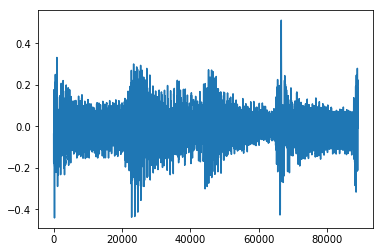

In [8]:
plt.plot(acc)
plt.show()
voc_path = '{0}/temp.wav'.format(model_path)
librosa.output.write_wav('{0}/temp.wav'.format(model_path), acc, 44100)
ipd.Audio(voc_path)

In [9]:
model.decay 

20074

decay:  0.36651160515668146


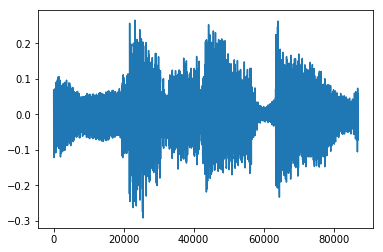

In [10]:
model = WaveUNet(hp.num_filters, hp.filter_size_x_d, hp.filter_size_y_d, hp.filter_size_x_u, hp.filter_size_y_u, hp.num_layers)
model.load_state_dict(torch.load('{0}/{1}.pt'.format(model_path, model_name)))
model.decay = 20074

y_hat = model(torch.tensor([to_specs(mix)]))
signal = restore(y_hat[0].detach().cpu().numpy())

s = signal[trim:-trim]
plt.plot(s)
plt.show()

gen_path = '{0}/gen.wav'.format(model_path)
librosa.output.write_wav(gen_path, s, 44100)
ipd.Audio(gen_path)

## Separation on full track

In [ ]:
# wav file -> tensor of spectrograms, shape=(num_intervals, 2, f, t)
def preprocess_track(track_path, start=0.0, length=None):
    y, sr = librosa.load(track_path, sr=None, offset=start, duration=length)
    
    gen_size = sampling_size-2*trim
    pad = gen_size - len(y)%gen_size
    y_p = np.concatenate((np.zeros(trim), y, np.zeros(pad), np.zeros(trim)))
    
    specs = []
    i = 0
    while i < len(y_p) - 2*trim:
        specs.append(to_specs(y_p[i:i+sampling_size]))
        i += gen_size

    return torch.tensor(specs), y, sr, pad

In [ ]:
model = WaveUNet(hp.num_filters, hp.filter_size_x_d, hp.filter_size_y_d, hp.filter_size_x_u, hp.filter_size_y_u, hp.num_layers)
model.load_state_dict(torch.load('{0}/{1}.pt'.format(model_path, model_name)))

track_name = 'Billy Joel_Piano Man'
mix_path = '{0}/other_tracks/{1}.wav'.format(model_path, track_name)
voc_path = '{0}/{1}/{2}_voc.wav'.format(model_path, model_name, track_name)

mix_specs, mix_signal, mix_sr, pad_len = preprocess_track(mix_path, length=None)


# create batches
batch_size = 5
i = 0
num_intervals = mix_specs.shape[0]
batches = []
while i < num_intervals:
    batches.append(mix_specs[i:i+batch_size])
    i = i + batch_size


# obtain estimated vocal spectrograms
voc_specs = None
for batch in tqdm_notebook(batches):
    voc_spec = model(batch)

    if voc_specs is None:
        voc_specs = voc_spec
    else:
        voc_specs = torch.cat((voc_specs, voc_spec), 0).detach()


# reconstruct vocal signal
voc_specs = voc_specs.cpu().numpy()
voc_signal = []
for voc_spec in voc_specs:
    voc_signal += list(restore(voc_spec))[trim:-trim]

voc_signal = np.array(voc_signal[:-pad_len])  

librosa.output.write_wav(voc_path, voc_signal, mix_sr)

### Generate vocals for all Musdb test tracks

In [ ]:
model = WaveUNet(hp.num_filters, hp.filter_size_x_d, hp.filter_size_y_d, hp.filter_size_x_u, hp.filter_size_y_u, hp.num_layers).to(device)
model.load_state_dict(torch.load('{0}/{1}.pt'.format(model_path, model_name)))

for i in range(2, 50):
    track_name = 'test_{0:02}'.format(i)
    mix_path = '{0}/mix/{1}.wav'.format(model_path, track_name)
    voc_path = '{0}/{1}/estimates/{2}/voc.wav'.format(model_path, model_name, track_name)

    mix_specs, mix_signal, mix_sr, pad_len = preprocess_track(mix_path, length=None)


    # create batches
    batch_size = 5
    i = 0
    num_intervals = mix_specs.shape[0]
    batches = []
    while i < num_intervals:
        batches.append(mix_specs[i:i+batch_size])
        i = i + batch_size


    # obtain estimated vocal spectrograms
    voc_specs = None
    for batch in tqdm_notebook(batches):
        voc_spec = model(batch.to(device))

        if voc_specs is None:
            voc_specs = voc_spec.detach().cpu()
        else:
            voc_specs = torch.cat((voc_specs, voc_spec.detach().cpu()), 0)


    # reconstruct vocal signal
    voc_specs = voc_specs.numpy()
    voc_signal = []
    for voc_spec in voc_specs:
        voc_signal += list(restore(voc_spec))[trim:-trim]

    voc_signal = np.array(voc_signal[:-pad_len])  

    librosa.output.write_wav(voc_path, voc_signal, mix_sr)

## Evaluation

In [ ]:
import museval
import math
import statistics as stats

S = [[],[],[],[]]
for i in range(50):
    track_name = 'test_{0:02}'.format(i)
    frame_scores = museval.eval_dir(reference_dir='{0}/{1}/reference/{2}'.format(model_path, model_name, track_name), 
                                    estimates_dir='{0}/{1}/estimates/{2}'.format(model_path, model_name, track_name)).scores['targets'][0]['frames']

    sdr, sir, sar, isr = [],[],[],[]
    for frame in frame_scores:
        f = frame['metrics']
        if not math.isnan(f['SDR']):
            sdr.append(f['SDR'])
        if not math.isnan(f['SIR']):
            sir.append(f['SIR'])
        if not math.isnan(f['SAR']):
            sar.append(f['SAR'])
        if not math.isnan(f['ISR']):
            isr.append(f['ISR'])

    sdr, sir, sar, isr = np.array(sdr, dtype=np.float), np.array(sir, dtype=np.float), np.array(sar, dtype=np.float), np.array(isr, dtype=np.float)
    S[0].append(sdr.mean())
    S[1].append(sir.mean())
    S[2].append(sar.mean())
    S[3].append(isr.mean())
    
    ipd.clear_output(wait=True)
    for s in S[:1]:
        plt.plot(s)
        plt.show()
        
    print('Global values..\n')
    print('SDR:', stats.mean(S[0]))
    print('SDR:', stats.median(S[0]))
#     print('SIR:', stats.mean(S[1]))
#     print('SAR:', stats.mean(S[2]))
#     print('ISR:', stats.mean(S[3]))




## Compare with SiSEC MUS 2018

In [ ]:
index = 21
mix, sr = librosa.load('{0}/mix/test_{1}.wav'.format(model_path, index), sr=None, offset=133, duration=2)
plt.plot(mix)
plt.show()

In [ ]:
track_name = 'test_{0:02}'.format(index)
ref, sr = librosa.load('{0}/{1}/reference/{2}/voc.wav'.format(model_path, model_name, track_name), sr=None, offset=133, duration=30)
est, sr_ = librosa.load('{0}/{1}/estimates/{2}/voc.wav'.format(model_path, model_name, track_name), sr=None, offset=133, duration=30)
sdr, isr, sir, sar, perm = museval.metrics.bss_eval(ref, est, window=sr, hop=sr)

print(sdr)
print(sdr[0].mean())

### Create reference, estimates folders

In [ ]:
for i in range(50):
    track = load_track_dict(musdb_test_path, i)
    mix = track['linear_mixture']
    voc = track['vocals']
    acc = mix-voc
    p = '{0}/{1}/reference/test_{2:02}'.format(model_path, model_name, i)
    os.mkdir(p)
    mix_path = '{0}/mix/test_{1:02}.wav'.format(model_path, i)
    voc_path = p+'/voc.wav'
    acc_path = p+'/acc.wav'
    librosa.output.write_wav(mix_path, mix, 44100)
    librosa.output.write_wav(voc_path, voc, 44100)
    librosa.output.write_wav(acc_path, acc, 44100)
    print(i)

In [ ]:
for i in range(50):
    track_name = 'test_{0:02}'.format(i)
    p = '{0}/{1}/estimates/test_{2:02}'.format(model_path, model_name, i)
    os.mkdir(p)
    acc, sr = librosa.load('{0}/{1}/reference/{2}/acc.wav'.format(model_path, model_name, track_name), sr=None)
    acc_path = p+'/acc.wav'
    librosa.output.write_wav(acc_path, acc, sr)
    print(i)